In [1]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd as psd_func
from pycbc.filter import sigma, match
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from simple_pe.waveforms import make_waveform
from simple_pe.param_est import find_peak_snr, matched_filter_network

# Disable pesummary warnings
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


In [2]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
init_guess = {'ecc10sqrd': 0, 'chirp_mass': 25, 'symmetric_mass_ratio': 0.20, 'chi_eff': 0.1}
target_snr = 20
t_bounds = [-0.05,0.05]
f_low = 20
sample_rate = 4096
tlen = 32
print(f'Analysing data with SNR of {target_snr}.')
print(true_dict)

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
data = make_waveform(true_dict, psd['H1'].delta_f, f_low, len(psd['H1']), 'TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data*target_snr/raw_snr}
init_guess['distance'] = raw_snr/target_snr

Analysing data with SNR of 20.
{'ecc10sqrd': 0.04000000000000001, 'chirp_mass': 24, 'symmetric_mass_ratio': 0.2222222222222222, 'chi_eff': 0}


/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)


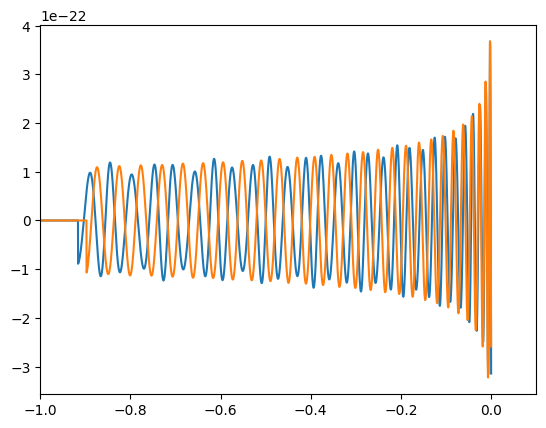

16.417437536466576
-31.999755859 3.749995869384293e-10
(16.417437536466572, {'H1': (-11.405374066581563-11.80888215137785j)}, {'H1': -0.002685546500000413})


In [3]:
init_guess_wf = make_waveform(init_guess, psd['H1'].delta_f, f_low, len(psd['H1']), 'TEOBResumS-Dali').to_timeseries()
data_t = data['H1'].to_timeseries()
plt.plot(data_t.sample_times, data_t)
plt.plot(init_guess_wf.sample_times, init_guess_wf)
plt.xlim(-1, 0.1)
plt.show()

m = match(data_t, init_guess_wf, low_frequency_cutoff=f_low, psd=psd['H1'])
print(m[0]*target_snr)

print(data_t.sample_times[0], data_t.sample_times[-1])
snr = matched_filter_network(
    ifos, data, psd, data_t.sample_times[0], data_t.sample_times[-1], init_guess_wf, f_low, dominant_mode=0,
    subsample_interpolation=False
)
print(snr)

In [4]:
# Find peak SNR
start = time.time()
t_start, t_end = t_bounds
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
bounds = [(10,100), (0.1,0.2499), (-0.99,0.99)]
peak_dict, snr = find_peak_snr(ifos, data, psd, t_start, t_end, init_guess, dx_directions, f_low,
                               bounds=bounds, approximant="TEOBResumS-Dali", method='scipy')
base_dict = {key: peak_dict[key] for key in dx_directions}
base_dict['ecc10sqrd'] = 0
end = time.time()
print(f'Peak SNR of {snr} found in {end-start} seconds.')
print(base_dict)

/home/ben.patterson/projects/simple-pe/simple_pe/waveforms/waveform_modes.py:372: UserWarning: PyCBC snr interpolation failed for mode 0 with error: index 206 is out of bounds for axis 0 with size 206. Falling back to index-based snr peak.
  warnings.warn(


Peak SNR of 19.39546841721584 found in 39.73465394973755 seconds.
{'chirp_mass': 24.43650207085936, 'symmetric_mass_ratio': 0.20815231777804172, 'chi_eff': 0.10386072657160966, 'ecc10sqrd': 0}
